# 4. Defining a Maze Environment

### About this notebook

This notebook was used in the 50.039 Deep Learning course at the Singapore University of Technology and Design.

**Author:** Matthieu DE MARI (matthieu_demari@sutd.edu.sg)

**Version:** 1.0 (04/02/2025)

**Requirements:**
- Python 3 (tested on v3.13.1)
- Matplotlib (tested on v3.10.0)
- Numpy (tested on v2.2.1)
- enum (Standard libraries for Python)

In [1]:
from enum import Enum, IntEnum
import numpy as np
import matplotlib.pyplot as plt

### Some Enums to begin

As you can see, these enums will be used to encode the state of a cell in the maze, the actions and the status of the game. Please self-study the code below, it should be rather self-explanatory.

In [2]:
class Cell(IntEnum):
    # Using an Enum for simplicity
    # 0 = Empty cell where the agent can move
    # 1 = Cell containing a wall, not accessible
    EMPTY = 0
    OCCUPIED = 1

class Action(IntEnum):
    # Using an Enum for simplicity
    # Self explanatory
    MOVE_LEFT = 0
    MOVE_RIGHT = 1
    MOVE_UP = 2
    MOVE_DOWN = 3

class Status(Enum):
    # Using an Enum for simplicity
    # Self explanatory
    WIN = 0
    LOSE = 1
    PLAYING = 2

### Our Maze object

Next, we will define our environment, using a Maze object. Please self-study the code, but do not worry too much about the rendering functions.

Our Maze object will have the following attributes:
- maze: Stores the layout of the maze (2D numpy array). The values 0 represents empty cells, 1 represents walls, and 2 represents the agent's current position.
- cells: A list of all possible cell coordinates (row, column) in the maze.
- empty: A list of all valid (non-wall) cells where the agent can move.
- exit_cell:The coordinates of the exit cell in the maze.
- actions: A list of all possible agent actions (MOVE_LEFT, MOVE_RIGHT, MOVE_UP, MOVE_DOWN).

In terms of rewards and Penalties:
- reward_exit: The reward for reaching the exit cell.
- penalty_move: A penalty applied for each move (encourages efficiency).
- penalty_visited: A penalty for revisiting a cell (discourages loops).
- penalty_impossible_move: A penalty for attempting an invalid move (e.g., into a wall).
- minimum_reward: Threshold for ending the game if the cumulative reward falls below this value.

Regarding the agent state:
- current_cell: The agent's current position in the maze.
- previous_cell: The agent's position before the last move.
- total_reward: The cumulative reward the agent has accumulated.
- visited: A set of cells the agent has already visited.

In terms of methods, we have methods related to initialization and setup, namely
- init(maze, start_cell, exit_cell): Initializes the maze environment, defines RL parameters.
- create_maze(maze, start_cell, exit_cell): Defines the maze layout, validates the exit cell, and populates the list of valid (empty) cells.
- define_rl_params(): Initializes RL parameters (rewards and penalties).

Next, there are methods related to the agent actions and state, these are important as they will later be used to play the game:
- reset(start_cell): Resets the maze to its initial state, placing the agent at the starting position and clearing rewards and visited cells.
- step(action): Performs the specified action (e.g., move left or right) and returns the new state, reward, and game status.
- execute(action): Handles the agent's movement logic, computes rewards, and updates the agent's position.
- possible_actions(cell): Returns a list of valid actions (based on the maze layout) that the agent can take from the specified cell.
- status(): Determines the game's status (WIN, LOSE, or PLAYING) based on the agent's position and cumulative reward.
- observe(): Returns the agent's current position as a numpy array.
- play(model, start_cell): Simulates a game where the provided model predicts the agent's actions.

Some additional attributes and methods regarding the rendering/visualization exist, but you do not have to worry about them too much, they are just some heavy matplotlib stuff to display the maze and wil be used later.

In [3]:
class Maze:
    """
    A Maze environment where an agent must navigate from a start cell to an exit cell.
    """
    def __init__(self, maze, start_cell, exit_cell):
        # Initialize maze
        self.create_maze(maze, start_cell, exit_cell)
        # Define the RL parameters for agent (rewards, etc.)
        self.define_rl_params()
        # Reset
        self.reset(start_cell)

    def create_maze(self, maze, start_cell, exit_cell):
        # Maze definition
        self.maze = maze
        nrows, ncols = self.maze.shape
        self.cells = [(col, row) for col in range(ncols) for row in range(nrows)]
        self.empty = [(col, row) for col in range(ncols) for row in range(nrows) if self.maze[row, col] == Cell.EMPTY]
        self.exit_cell = exit_cell
        self.empty.remove(self.exit_cell)
        self.start_cell = start_cell
        
    def define_rl_params(self):
        # List of all 4 possible actions
        self.actions = [Action.MOVE_LEFT, Action.MOVE_RIGHT, Action.MOVE_UP, Action.MOVE_DOWN]
        # Reward for reaching the exit
        self.reward_exit = 10.0
        # Penalty applied everytime a move is taken (encourages the agent to find the exit ASAP)
        self.penalty_move = -0.05
        # Penalty for revisiting a cell (encourages the agent not to revisit cells it has already gone through)
        self.penalty_visited = -0.25
        # Penalty for invalid moves (encourages agent not to bump into walls)
        self.penalty_impossible_move = -0.75
        # Threshold to force game end, if cumulated reward falls below this value
        self.minimum_reward = -10
        
    def reset(self, start_cell):
        """
        Reset the maze to its initial state.
        """
        self.previous_cell = self.current_cell = start_cell
        self.total_reward = 0.0
        self.visited = set()
        return self.observe()

    def step(self, action):
        """
        Perform an action in the maze.
        """
        reward = self.execute(action)
        self.total_reward += reward
        status = self.status()
        state = self.observe()
        return state, reward, status

    def execute(self, action):
        """
        Execute an action and return the reward of this action.
        """
        # Compute possible actions in the current location
        possible_actions = self.possible_actions(self.current_cell)
        if not possible_actions:
            # No valid moves, force game over
            return self.minimum_reward - 1
        # Tried going into a wall, apply penalty and do nothing in terms of movement
        if action not in possible_actions:
            return self.penalty_impossible_move
        # Otherwise, move the agent based on the selected action
        col, row = self.current_cell
        if action == Action.MOVE_LEFT:
            col -= 1
        elif action == Action.MOVE_UP:
            row -= 1
        elif action == Action.MOVE_RIGHT:
            col += 1
        elif action == Action.MOVE_DOWN:
            row += 1
        # Update cell position
        self.previous_cell = self.current_cell
        self.current_cell = (col, row)
        # Check for penalties or rewards based on the new cell
        if self.current_cell == self.exit_cell:
            return self.reward_exit
        elif self.current_cell in self.visited:
            # Apply penalty for revisiting
            return self.penalty_visited
        else:
            # Mark as visited
            self.visited.add(self.current_cell)
            return self.penalty_move

    def possible_actions(self, cell = None):
        """
        Determine all valid actions from the current cell.
        """
        if cell is None:
            col, row = self.current_cell
        else:
            col, row = cell
        possible_actions = self.actions.copy()
        nrows, ncols = self.maze.shape
        # Update list of moves
        # For each direction, remove from list of actions if it leads into a wall or out of the maze
        if row == 0 or self.maze[row - 1, col] == Cell.OCCUPIED:
            possible_actions.remove(Action.MOVE_UP)
        if row == nrows - 1 or self.maze[row + 1, col] == Cell.OCCUPIED:
            possible_actions.remove(Action.MOVE_DOWN)
        if col == 0 or self.maze[row, col - 1] == Cell.OCCUPIED:
            possible_actions.remove(Action.MOVE_LEFT)
        if col == ncols - 1 or self.maze[row, col + 1] == Cell.OCCUPIED:
            possible_actions.remove(Action.MOVE_RIGHT)
        return possible_actions

    def status(self):
        """
        Determine the current status of the game.
        """
        if self.current_cell == self.exit_cell:
            # Reached the exit
            return Status.WIN
        elif self.total_reward < self.minimum_reward:
            # Cumulative reward going below minimum_reward means
            # too many moves taken without finding the exit
            return Status.LOSE
        else:
            # Otherwise, still playing
            return Status.PLAYING

    def observe(self):
        """
        Helper function that returns the current state of the agent.
        """
        return np.array([[*self.current_cell]])

    def play(self, model, start_cell = (0, 0)):
        """
        Play a game using the provided model to predict actions.
        """
        self.reset(start_cell)
        state = self.observe()
        while True:
            # Decide on action to use in state
            action = model.predict(state)
            # Update environment by applying action
            state, reward, status = self.step(action)
            # When game ends (exit reach or too many moves), return outcome (win or lose)
            if status in (Status.WIN, Status.LOSE):
                return status
    
    def draw_full_maze(self):
        """
        Draw the entire maze with walls, valid cells, start, and exit positions.
        Ensures (0,0) is at the top-left and (nrows-1, ncols-1) at the bottom-right.
        """
        nrows, ncols = self.maze.shape
        fig, ax = plt.subplots(figsize = (6, 6), tight_layout = True)
        # Display the maze
        ax.imshow(self.maze, cmap = "Greys", origin = "upper")
        # Set major ticks to match correct grid positions
        ax.set_xticks(np.arange(ncols))
        ax.set_yticks(np.arange(nrows))
        # Label axes correctly with 0 at top-left
        ax.set_xticklabels(np.arange(ncols))
        ax.set_yticklabels(np.arange(nrows))
        # Draw grid lines
        ax.set_xticks(np.arange(-0.5, ncols, 1), minor = True)
        ax.set_yticks(np.arange(-0.5, nrows, 1), minor = True)
        ax.grid(which = "minor", color = "black", linestyle = "-", linewidth = 0.5)
        # Mark the starting position
        start_col, start_row = self.start_cell
        ax.plot(start_col, start_row, "rs", markersize = 20)
        ax.text(start_col, start_row, "Start", ha = "center", va = "center", color = "white")
        # Mark the exit position
        exit_col, exit_row = self.exit_cell
        ax.plot(exit_col, exit_row, "gs", markersize = 20)
        ax.text(exit_col, exit_row, "Exit", ha = "center", va = "center", color = "white")
        plt.show()

### Explanations on how to use the Maze object

In the code below, we show the important ways to create and use the Maze environment. It start with a layout for the maze, which will be a 4 by 4 grid, shown below. We will then decide that the start cell is top left (0, 0) and the exit cell is bottom right (3, 3).

Then, we will reset the game (efficiently starting the game for the first time) and show the maze. All moves are shown on each cell as no agent has currently been trained to recognize the best move to play in each cell yet.

Maze initialized.

Initial state: [[0 0]]



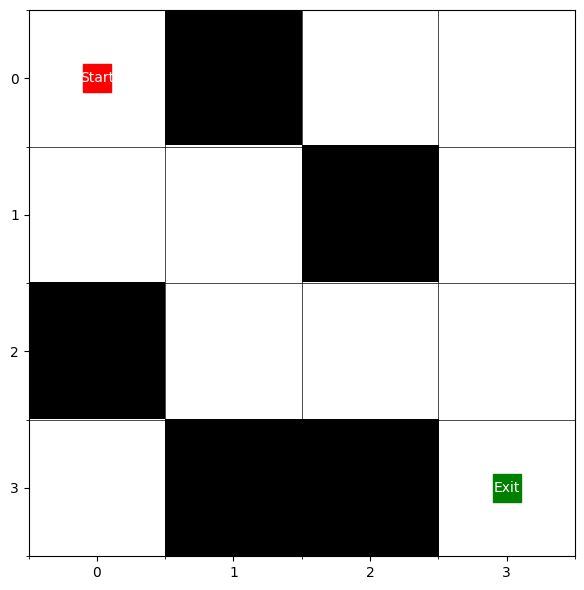

In [4]:
# Define a simple maze layout
maze_layout = np.array([[0, 1, 0, 0],
                        [0, 0, 1, 0],
                        [1, 0, 0, 0],
                        [0, 1, 1, 0]])
# Initialize the Maze environment
maze = Maze(maze = maze_layout, start_cell = (0, 0), exit_cell = (3, 3))
print("Maze initialized.\n")
# Reset the maze
state = maze.reset(start_cell = (0, 0))
print(f"Initial state: {state}\n")
# Display the maze
maze.draw_full_maze()

The functions below can be used to check the current agent state and the possible actions in any cell (meaning actions that will not lead into walls).

In [5]:
# Show possible actions from a specific cell
specific_cell = (2, 2)
possible_actions = maze.possible_actions(cell = specific_cell)
act = [action.name for action in possible_actions]
print(f"Possible actions from cell {specific_cell}: {act}")

# Observe the current state
observation = maze.observe()
print(f"Current position for agent: {observation}")

Possible actions from cell (2, 2): ['MOVE_LEFT', 'MOVE_RIGHT']
Current position for agent: [[0 0]]


We will then play a sequence of 5 actions: down, down, right, right, down, right, right, up, down, down.

Some of these actions will change the agent state, moving it to a new location. Some of these actions will, however, bump into walls and lead to penalties and no changes of state. You can refer to the prints below. Notice how we use the step() method each time to update the game with a new action.

In [6]:
# Demonstrate taking a few actions
actions = [Action.MOVE_DOWN, Action.MOVE_DOWN, Action.MOVE_RIGHT, Action.MOVE_RIGHT, Action.MOVE_DOWN, \
           Action.MOVE_RIGHT, Action.MOVE_RIGHT, Action.MOVE_UP, Action.MOVE_DOWN, Action.MOVE_DOWN]

# Use the sequence of actions
print("Performing actions in the maze:\n")
for i, action in enumerate(actions):
    print("-----")
    print(f"Current state: {state}")
    print(f"Step {i + 1}: Executing action {action.name}")
    state, reward, status = maze.step(action)
    print(f"New state: {state}")
    print(f"Reward: {reward}")
    print(f"Status: {status.name}\n")

    if status != Status.PLAYING:
        print(f"Game ended with status: {status.name}")
        break

Performing actions in the maze:

-----
Current state: [[0 0]]
Step 1: Executing action MOVE_DOWN
New state: [[0 1]]
Reward: -0.05
Status: PLAYING

-----
Current state: [[0 1]]
Step 2: Executing action MOVE_DOWN
New state: [[0 1]]
Reward: -0.75
Status: PLAYING

-----
Current state: [[0 1]]
Step 3: Executing action MOVE_RIGHT
New state: [[1 1]]
Reward: -0.05
Status: PLAYING

-----
Current state: [[1 1]]
Step 4: Executing action MOVE_RIGHT
New state: [[1 1]]
Reward: -0.75
Status: PLAYING

-----
Current state: [[1 1]]
Step 5: Executing action MOVE_DOWN
New state: [[1 2]]
Reward: -0.05
Status: PLAYING

-----
Current state: [[1 2]]
Step 6: Executing action MOVE_RIGHT
New state: [[2 2]]
Reward: -0.05
Status: PLAYING

-----
Current state: [[2 2]]
Step 7: Executing action MOVE_RIGHT
New state: [[3 2]]
Reward: -0.05
Status: PLAYING

-----
Current state: [[3 2]]
Step 8: Executing action MOVE_UP
New state: [[3 1]]
Reward: -0.05
Status: PLAYING

-----
Current state: [[3 1]]
Step 9: Executing action

We can then confirm the visited cells and the final cumulative reward for this sequence of actions.

In [7]:
# Display visited cells
print("Agent has visited the following cells:", maze.visited)

# Display cumulated reward
print("Total reward for sequence of moves", round(maze.total_reward, 3))

Agent has visited the following cells: {(0, 1), (1, 2), (3, 1), (1, 1), (2, 2), (3, 2)}
Total reward for sequence of moves 7.95
